# Simulation-based Calibration in SBI

After a posterior has been trained given a simulation, predictions from this posterior should be made subject to several diagnostical tests. [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) are one such way to "critique" a trained model. Another important approach to such diagnostics is simulation-based calibration as reported by [Talts et al, 2018](https://arxiv.org/abs/1804.06788).

**Simulation-based calibration** (SBC) boils down to a visual (qualitative) way as well as a quantitive measure to check, if the uncertainties obtained from the ensemble of posterior samples meets expectations. In this way, SBC can unveil if the uncertainties of the posterior samples can be considered well calibrated (or healthy if you will). SBC can be used to uncover malignant posteriors. SBC cannot be used to fix this posterior. As such, SBC can be viewed as a necessary condition for a valid inference using a posterior.

## in a nutshell

SBC repeats posterior inference to obtain predicted samples of $x_{true}$ (obtained from $simulator(\theta_{true})$). SBC then ranks these $\theta_{pp}$ with respect to $\theta_{true}$. This rank is calculated by counting those samples $\theta_{pp}$ which fall below $\theta_{true}$. 

### key ideas behind SBC

The core idea behind SBC is two fold: 

- SBC ranks of posterior samples with respect to their ground truth follow a uniform distribution.  
(If the SBC ranks are not uniformly distributed, the posterior is not well calibrated.)

- samples from the data averaged posterior are distributed according to the prior

### What can SBC diagnose?

**SBC can inform us whether we are not wrong.** However, it cannot tell us whether we are right. SBC checks a necessary condition. For example, imagine you run SBC using the prior as a posterior. The ranks would be perfectly uniform. But the inference would be wrong.

**The [Posterior Predictive Checks](12_diagnosis_posterior_predictive_check.ipynb) can be seen as the complementary sufficient check** for the posterior (only as a methaphor, no theoretical guarantees here). Using the prior as a posterior and then doing predictive checks would clearly show that inference failed. 

So SBC can ...

- tell us whether a method produces posterior samples $\theta_{pp}$ that have a systematic negative or positive bias (shift in the mean of the predictions)
- tell us whether a method produces posterior samples $\theta_{pp}$ that are systematically over- or underdispersed (too large or too small variance) 

## a healthy posterior

Let's take the gaussian linear simulation and run inference with (S)NPE on it. As we do not perform any rounds, we actually only do neural posterior estimation (NPE).

In [1]:
import torch
_ = torch.manual_seed(11)
from torch import eye, ones, zeros
from torch.distributions import MultivariateNormal

from sbi.analysis import check_sbc, run_sbc, get_nltp
from sbi.inference import SNPE, SNPE_C, prepare_for_sbi, simulate_for_sbi
from sbi.simulators import linear_gaussian, diagonal_linear_gaussian
from sbi.utils import BoxUniform

In [2]:
num_dim = 2
num_simulations = 5_000

likelihood_loc = 0. #zeros(num_dim)
likelihood_scale = 1e-2 #eye(num_dim)

prior_mean = ones(num_dim)
prior_cov = 2*eye(num_dim)
prior = MultivariateNormal(loc=prior_mean, covariance_matrix=prior_cov, validate_args=False)
#prior = BoxUniform(zeros(num_dim), ones(num_dim))


## An ideal case

To explore SBC, we make our life easy and assume that we deal with a problem where the likelihood is modelled by an identity mapping.

In [3]:
def simulator(theta, loc = likelihood_loc, scale = likelihood_scale):
    """ linear gaussian inspired by sbibm
    s://github.com/sbi-benchmark/sbibm/blob/15f068a08a938383116ffd92b92de50c580810a3/sbibm/tasks/gaussian_linear/task.py#L74
    """
    num_dim = theta.shape[-1]
    cov_ = scale*eye(num_dim)

    value = MultivariateNormal(loc=(theta+loc), covariance_matrix=cov_, validate_args=False).sample()
    return value

# def simulator(theta, loc = likelihood_loc, scale = likelihood_scale):
#     return theta + loc + torch.randn_like(theta) * scale

simulator, prior = prepare_for_sbi(simulator, prior)
theta, x = simulate_for_sbi(simulator, prior, num_simulations)


Running 5000 simulations.:   0%|          | 0/5000 [00:00<?, ?it/s]

In [4]:
# we define a hold-out sample of 1 to build an observation
theta_holdout = prior.sample((100,))
x_holdout = simulator(theta_holdout)

theta_o = theta_holdout[42,]
x_o = simulator(theta_o)
print("theta:", theta_o)
print("x    :", x_o)

theta: tensor([0.6873, 1.0533])
x    : tensor([0.6942, 1.0899])


In [5]:
from sbi.utils.get_nn_models import posterior_nn

#defn = posterior_nn(model='mdn', hidden_features=16, num_components=num_dim)
defn = posterior_nn(model='nsf')
inferer = SNPE(prior, density_estimator=defn)

# let's not save the density_estimator in order to do NPE
# (we have enough simulations)
_ = inferer.append_simulations(theta, x).train(
        training_batch_size=num_simulations // 30
    )

 Training neural network. Epochs trained:  1

 Training neural network. Epochs trained:  2

 Training neural network. Epochs trained:  3

 Training neural network. Epochs trained:  4

 Training neural network. Epochs trained:  5

 Training neural network. Epochs trained:  6

 Training neural network. Epochs trained:  7

 Training neural network. Epochs trained:  8

 Training neural network. Epochs trained:  9

 Training neural network. Epochs trained:  10

 Training neural network. Epochs trained:  11

 Training neural network. Epochs trained:  12

 Training neural network. Epochs trained:  13

 Training neural network. Epochs trained:  14

 Training neural network. Epochs trained:  15

 Training neural network. Epochs trained:  16

 Training neural network. Epochs trained:  17

 Training neural network. Epochs trained:  18

 Training neural network. Epochs trained:  19

 Training neural network. Epochs trained:  20

 Training neural network. Epochs trained:  21

 Training neural network. Epochs trained:  22

 Training neural network. Epochs trained:  23

 Training neural network. Epochs trained:  24

 Training neural network. Epochs trained:  25

 Training neural network. Epochs trained:  26

 Training neural network. Epochs trained:  27

 Training neural network. Epochs trained:  28

 Training neural network. Epochs trained:  29

 Training neural network. Epochs trained:  30

 Training neural network. Epochs trained:  31

 Training neural network. Epochs trained:  32

 Training neural network. Epochs trained:  33

 Training neural network. Epochs trained:  34

 Training neural network. Epochs trained:  35

 Training neural network. Epochs trained:  36

 Training neural network. Epochs trained:  37

 Training neural network. Epochs trained:  38

 Training neural network. Epochs trained:  39

 Training neural network. Epochs trained:  40

 Training neural network. Epochs trained:  41

 Training neural network. Epochs trained:  42

 Training neural network. Epochs trained:  43

 Training neural network. Epochs trained:  44

 Training neural network. Epochs trained:  45

 Training neural network. Epochs trained:  46

 Training neural network. Epochs trained:  47

 Training neural network. Epochs trained:  48

 Training neural network. Epochs trained:  49

 Training neural network. Epochs trained:  50

 Training neural network. Epochs trained:  51

 Training neural network. Epochs trained:  52Neural network successfully converged after 52 epochs.


In [6]:
posterior = inferer.build_posterior()
posterior_samples = posterior.sample((15_000,), x = x_o).detach()

print(theta_o)
print(posterior_samples.median(dim=0).values)
print(posterior_samples.mean(dim=0))

Drawing 15000 posterior samples:   0%|          | 0/15000 [00:00<?, ?it/s]

tensor([0.6873, 1.0533])
tensor([0.6889, 1.1016])
tensor([0.6892, 1.1015])


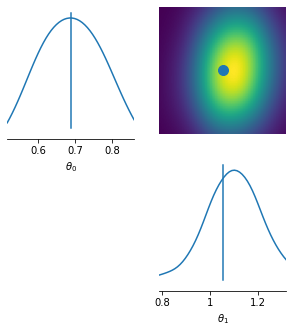

In [10]:
from sbi.analysis import pairplot

fig, ax = pairplot(
    samples=posterior_samples,
    points=theta_o,
    limits=list(zip(.75*theta_o.flatten(), 1.25*theta_o.flatten())),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

Drawing 15000 posterior samples:   0%|          | 0/15000 [00:00<?, ?it/s]

tensor([ 2.0065, -1.0301])
tensor([ 1.7799, -0.9702])


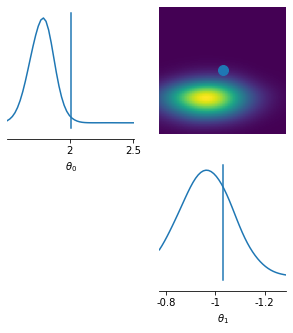

In [9]:
theta_oo = theta_holdout[43,]
x_oo = simulator(theta_oo)

posterior_sampless = posterior.sample((15_000,), x = x_oo).detach()

print(theta_oo)
print(posterior_sampless.mean(dim=0))

fig, ax = pairplot(
    samples=posterior_sampless,
    points=theta_oo,
    limits=list(zip(.75*theta_oo.flatten(), 1.25*theta_oo.flatten())),
    upper=['kde'],
    diag=['kde'],
    figsize=(5,5),
    labels=[rf"$\theta_{d}$" for d in range(3)]
)

We have a working and trained posterior at this point which can be considered perfect. Judging from the pairplot above, everything is normal if not ideal.
Let's look at the SBC metrics in a case, where all predictions should be healthy.

In [20]:
num_sbc_runs = 1000
thetas = prior.sample((num_sbc_runs,))
xs = simulator(thetas)

In [21]:
posterior.set_default_x(x_o)
ranks, dap_samples = run_sbc(thetas, xs, posterior, num_workers=1)

Running 1000 sbc samples.:   0%|          | 0/1000 [00:00<?, ?it/s]

In [22]:
check_stats = check_sbc(ranks, thetas, dap_samples, 1_000)
print(check_stats)

{'ks_pvals': tensor([0., 0.]), 'c2st_ranks': tensor([0.7270, 0.7200]), 'c2st_dap': tensor([0.4940, 0.4660])}


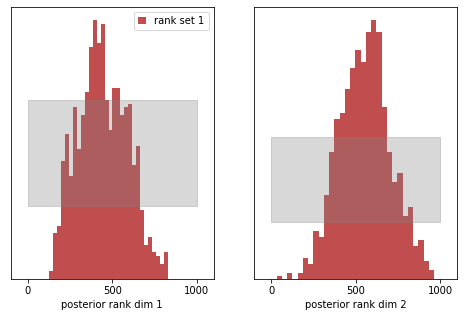

In [24]:
from sbi.analysis.plot import sbc_rank_plot

f, ax = sbc_rank_plot(ranks, 1_000, plot_type = "hist", num_bins=30)